    This ipynb is the best script so far, which could be used for our project's web application as the training model. It inherits the major idea from ANN_example2.ipynb. There are some details in this script:
    1. It involves over hundred of input features, depending on with Line we choose. For example, 39A has 73 bus stations in total. Thus there are 73 planned Arrival Time as the input features and 73 actual arrival Time as the output features
    2. The get the dateset for each tripid, we need to make sure each tripid + date has the completed arrival time for each stations. As there are some stations' record missed in full data file, we need to workaround it. The solution we used is to fill the missed station with a predicted planned arrival time and actual arrival time (previous time + 15 second). However, this replacement solution is restricted, in which if there are more than 10% missed stations occurred in one tripid row, we will drop this tripid row because the data quality is not satisfied.
    3. "Plot output" will show how well the trained model is and how doese it look like.
    4. "Graph of five groups of Errors on ANN model predictions" will show how good the predictions are, comparing with the actual arrival times. We use 2 sets of data: one is completed dataset (only about 70 rows in total, each test set has 5 rows), the other one is filled dataset (over 900 rows in total, each test set has 162 rows)
    5. We will also calculate the accuracy based on 10-fold crossing-validation
    
    Development Date: 2018.06.30

In [1]:
import csv
import pandas as pd
sample_df = pd.read_csv("LeaveTimesTrips_JUN.csv")
sample_df.count()
#sample_df.head()

TripId             4208619
DataSource         4208619
DayOfService       4208619
ProgrNumber        4208619
StopPointId        4208619
PlannedTime_Arr    4208619
PlannedTime_Dep    4208619
ActualTime_Arr     4208619
ActualTime_Dep     4208619
VehicleId          4208619
Passengers               0
Passengersin             0
Distance                 0
Suppressed               0
JustificationId          0
LastUpdate               0
Note                     0
LineId             4208619
RouteId            4208619
Direction          4208619
dtype: int64

In [65]:
# How many lines
lines = sample_df['LineId'].unique()
print(len(lines))

123


In [16]:
sample_df = sample_df[(sample_df['LineId']=='39A')]
sample_df.head()

,TripId,DataSource,DayOfService,ProgrNumber,StopPointId,PlannedTime_Arr,PlannedTime_Dep,ActualTime_Arr,ActualTime_Dep,VehicleId,Passengers,Passengersin,Distance,Suppressed,JustificationId,LastUpdate,Note,LineId,RouteId,Direction
260,5108092,DB,2017-06-28,58,751,42071,42071,44775,44782,1000922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39A,39A_43,2
261,5108092,DB,2017-06-28,26,4747,39484,39484,39865,39957,1000922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39A,39A_43,2
262,5108092,DB,2017-06-28,43,1713,40674,40674,41219,41219,1000922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39A,39A_43,2
263,5108092,DB,2017-06-28,59,752,42137,42137,44875,44886,1000922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39A,39A_43,2
264,5108092,DB,2017-06-28,27,1845,39882,39882,40305,40314,1000922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39A,39A_43,2


In [17]:
stations = sample_df['ProgrNumber'].sort_values().unique()

In [18]:
# Drop several columns
sample_df = sample_df.drop(['DataSource','Passengers', 'Passengersin','Distance', 'Suppressed','JustificationId','LastUpdate','Note','VehicleId', 'LineId', 'RouteId'], axis=1)
sample_df.head()

,TripId,DayOfService,ProgrNumber,StopPointId,PlannedTime_Arr,PlannedTime_Dep,ActualTime_Arr,ActualTime_Dep,Direction
260,5108092,2017-06-28,58,751,42071,42071,44775,44782,2
261,5108092,2017-06-28,26,4747,39484,39484,39865,39957,2
262,5108092,2017-06-28,43,1713,40674,40674,41219,41219,2
263,5108092,2017-06-28,59,752,42137,42137,44875,44886,2
264,5108092,2017-06-28,27,1845,39882,39882,40305,40314,2


In [19]:
sample_a_df = sample_df[(sample_df['Direction']) == 1]
sample_b_df = sample_df[(sample_df['Direction']) == 2]

In [20]:
tripids = sample_a_df['TripId'].sort_values().unique()
len(tripids)

413

In [21]:
dayOfService = sample_a_df[(sample_a_df['TripId'] == 5002343)].DayOfService.sort_values().unique()
for day in dayOfService:
    print(day)

2017-06-01
2017-06-02
2017-06-07
2017-06-08
2017-06-09


In [22]:
temp = sample_a_df[(sample_a_df['TripId'] == 5002343) & (sample_a_df['ProgrNumber'] == 1)]
temp

,TripId,DayOfService,ProgrNumber,StopPointId,PlannedTime_Arr,PlannedTime_Dep,ActualTime_Arr,ActualTime_Dep,Direction
309958,5002343,2017-06-07,1,767,28200,28200,28231,28231,1
310026,5002343,2017-06-08,1,767,28200,28200,28172,28172,1
2113464,5002343,2017-06-09,1,767,28200,28200,28259,28259,1
3128291,5002343,2017-06-01,1,767,28200,28200,28182,28182,1
4056514,5002343,2017-06-02,1,767,28200,28200,28163,28163,1


In [33]:
count = 0
tag = 0
for tripid in tripids:
    # Pick the first 100 trips
    if tag == 100:
        break
    else:
        tag += 1
    dayOfService = sample_a_df[(sample_a_df['TripId'] == tripid)].DayOfService.sort_values().unique()
    for day in dayOfService:
        
        timepool = {}
        pool = []
        isUseful = True
        for i in stations:
            oneStationRow = sample_a_df[(sample_a_df['TripId'] == tripid) & (sample_a_df['DayOfService'] == day) & (sample_a_df['ProgrNumber'] == i )]
            #print(oneStationRow)
            try:
                #timepool.append([oneStationRow['PlannedTime_Arr'].iloc[0], oneStationRow['ActualTime_Arr'].iloc[0]])
                timepool['a_{}'.format(i)] = oneStationRow['PlannedTime_Arr'].iloc[0]
                timepool['b_{}'.format(i)] = oneStationRow['ActualTime_Arr'].iloc[0]
                #last_plannedtime_arr = oneStationRow['PlannedTime_Arr'].iloc[0]
                #last_actualtime_arr = oneStationRow['ActualTime_Arr'].iloc[0]
            except:
                #timepool['a_{}'.format(i)] = last_plannedtime_arr
                #timepool['b_{}'.format(i)] = last_actualtime_arr
                #continue
                isUseful = False
                break
        #print('----'*20)
        #print(timepool)
        if isUseful == True:
            print(tripid, day, "===" * 20)
            print(timepool)
            if count == 0:
                df = pd.DataFrame(data=timepool,index=[0])
            else:
                df.loc[count] = timepool
            count += 1
    if count % 10 == 0:
        print(count)

5002343 2017-06-07 ============================================================
{'a_55': 31890, 'b_2': 28367, 'a_18': 29010, 'b_66': 33004, 'b_51': 32254, 'a_1': 28200, 'b_43': 31483, 'a_23': 29502, 'a_5': 28419, 'b_47': 31948, 'a_72': 32326, 'a_56': 31924, 'b_19': 29357, 'b_68': 33130, 'a_37': 30705, 'b_52': 32300, 'b_32': 30668, 'b_23': 29847, 'b_71': 33257, 'a_69': 32267, 'a_63': 32097, 'a_32': 30323, 'a_34': 30435, 'a_11': 28683, 'b_35': 30850, 'a_16': 28928, 'b_39': 31256, 'b_14': 28966, 'b_11': 28850, 'a_7': 28500, 'b_59': 32629, 'a_22': 29393, 'a_58': 31996, 'b_60': 32779, 'b_33': 30811, 'a_14': 28839, 'a_35': 30460, 'b_37': 31047, 'b_30': 30559, 'a_27': 29880, 'a_47': 31567, 'b_63': 32874, 'a_41': 30989, 'b_65': 32975, 'b_21': 29542, 'a_31': 30229, 'a_17': 28958, 'a_48': 31632, 'a_4': 28396, 'b_27': 30291, 'a_39': 30861, 'a_10': 28637, 'a_61': 32058, 'a_9': 28592, 'a_28': 29964, 'b_18': 29250, 'a_73': 32344, 'a_43': 31099, 'a_49': 31661, 'a_19': 29104, 'b_64': 32918, 'a_38': 30

5003709 2017-06-07 ============================================================
{'a_55': 35152, 'b_2': 31434, 'a_18': 32177, 'b_66': 36186, 'b_51': 35564, 'a_1': 31200, 'b_43': 34894, 'a_23': 32842, 'a_5': 31455, 'b_47': 35335, 'a_72': 35580, 'a_56': 35182, 'b_19': 32675, 'b_68': 36301, 'a_37': 34026, 'b_52': 35602, 'b_32': 34189, 'b_23': 33222, 'b_71': 36448, 'a_69': 35521, 'a_63': 35351, 'a_32': 33716, 'a_34': 33793, 'a_11': 31810, 'b_35': 34312, 'a_16': 32088, 'b_39': 34653, 'b_14': 32190, 'b_11': 31967, 'a_7': 31557, 'b_59': 35862, 'a_22': 32696, 'a_58': 35250, 'b_60': 35932, 'b_33': 34272, 'a_14': 31987, 'a_35': 33822, 'b_37': 34537, 'b_30': 34103, 'a_27': 33289, 'a_47': 34853, 'b_63': 36078, 'a_41': 34275, 'b_65': 36171, 'b_21': 32874, 'a_31': 33618, 'a_17': 32121, 'a_48': 34919, 'a_4': 31429, 'b_27': 33667, 'a_39': 34185, 'a_10': 31754, 'a_61': 35312, 'a_9': 31692, 'a_28': 33367, 'b_18': 32516, 'a_73': 35598, 'a_43': 34377, 'a_49': 34949, 'a_19': 32306, 'b_64': 36123, 'a_38': 34

5006287 2017-06-10 ============================================================
{'a_55': 37736, 'b_2': 34304, 'a_18': 35160, 'b_66': 37767, 'b_51': 37231, 'a_1': 34200, 'b_43': 36593, 'a_23': 35532, 'a_5': 34456, 'b_47': 37020, 'a_72': 38428, 'a_56': 37762, 'b_19': 34958, 'b_68': 37857, 'a_37': 36540, 'b_52': 37256, 'b_32': 36069, 'b_23': 35344, 'b_71': 37986, 'a_69': 38325, 'a_63': 38020, 'a_32': 36240, 'a_34': 36360, 'a_11': 34794, 'b_35': 36249, 'a_16': 35040, 'b_39': 36396, 'b_14': 34691, 'b_11': 34627, 'a_7': 34548, 'b_59': 37528, 'a_22': 35474, 'a_58': 37839, 'b_60': 37563, 'b_33': 36217, 'a_14': 34955, 'a_35': 36420, 'b_37': 36324, 'b_30': 35971, 'a_27': 35878, 'a_47': 37456, 'b_63': 37641, 'a_41': 36780, 'b_65': 37738, 'b_21': 35094, 'a_31': 36153, 'a_17': 35085, 'a_48': 37528, 'a_4': 34434, 'b_27': 35734, 'a_39': 36660, 'a_10': 34740, 'a_61': 37950, 'a_9': 34680, 'a_28': 35942, 'b_18': 34900, 'a_73': 38460, 'a_43': 36900, 'a_49': 37560, 'a_19': 35253, 'b_64': 37681, 'a_38': 36

5007980 2017-06-07 ============================================================
{'a_55': 32752, 'b_2': 28951, 'a_18': 29777, 'b_66': 34069, 'b_51': 33359, 'a_1': 28800, 'b_43': 32569, 'a_23': 30442, 'a_5': 29055, 'b_47': 33041, 'a_72': 33180, 'a_56': 32782, 'b_19': 30076, 'b_68': 34170, 'a_37': 31626, 'b_52': 33408, 'b_32': 31675, 'b_23': 30587, 'b_71': 34312, 'a_69': 33121, 'a_63': 32951, 'a_32': 31316, 'a_34': 31393, 'a_11': 29410, 'b_35': 31862, 'a_16': 29688, 'b_39': 32355, 'b_14': 29705, 'b_11': 29492, 'a_7': 29157, 'b_59': 33702, 'a_22': 30296, 'a_58': 32850, 'b_60': 33784, 'b_33': 31785, 'a_14': 29587, 'a_35': 31422, 'b_37': 32055, 'b_30': 31523, 'a_27': 30889, 'a_47': 32453, 'b_63': 33952, 'a_41': 31875, 'b_65': 34041, 'b_21': 30235, 'a_31': 31218, 'a_17': 29721, 'a_48': 32519, 'a_4': 29029, 'b_27': 31160, 'a_39': 31785, 'a_10': 29354, 'a_61': 32912, 'a_9': 29292, 'a_28': 30967, 'b_18': 29993, 'a_73': 33198, 'a_43': 31977, 'a_49': 32549, 'a_19': 29906, 'b_64': 33990, 'a_38': 31

5009571 2017-06-08 ============================================================
{'a_55': 36371, 'b_2': 32599, 'a_18': 33398, 'b_66': 37635, 'b_51': 36969, 'a_1': 32400, 'b_43': 35668, 'a_23': 34095, 'a_5': 32671, 'b_47': 36706, 'a_72': 36799, 'a_56': 36402, 'b_19': 33637, 'b_68': 37746, 'a_37': 35276, 'b_52': 37006, 'b_32': 35052, 'b_23': 34255, 'b_71': 37886, 'a_69': 36740, 'a_63': 36570, 'a_32': 34998, 'a_34': 35091, 'a_11': 33028, 'b_35': 35236, 'a_16': 33285, 'b_39': 35486, 'b_14': 33226, 'b_11': 33136, 'a_7': 32768, 'b_59': 37312, 'a_22': 33935, 'a_58': 36469, 'b_60': 37396, 'b_33': 35152, 'a_14': 33191, 'a_35': 35132, 'b_37': 35388, 'b_30': 34956, 'a_27': 34583, 'a_47': 36066, 'b_63': 37476, 'a_41': 35490, 'b_65': 37606, 'b_21': 33861, 'a_31': 34912, 'a_17': 33327, 'a_48': 36133, 'a_4': 32650, 'b_27': 34694, 'a_39': 35380, 'a_10': 32980, 'a_61': 36531, 'a_9': 32916, 'a_28': 34662, 'b_18': 33460, 'a_73': 36817, 'a_43': 35585, 'a_49': 36163, 'a_19': 33527, 'b_64': 37531, 'a_38': 35

In [1]:
df.to_csv("39A_73stations_JUN.csv")

NameError: name 'df' is not defined

In [176]:
#ErrorArray = []

In [208]:
import csv
import pandas as pd
new_df = pd.read_csv("39A_73stations_JUN.csv")
#new_df = pd.read_csv("FINAL_39A_73stations_JUN.csv")

In [209]:
# BP neural networking training
import numpy as np
#from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
# X Descriptive features (6 continous features)
# y Target feature (happiness_class)
a_columns = []
b_columns = []
#columns = []
for i in range(1,74):
    #columns.append('a_{}'.format(i))
    #columns.append('b_{}'.format(i))
    a_columns.append('a_{}'.format(i))
    b_columns.append('b_{}'.format(i))

X = pd.concat([new_df[a_columns]], axis=1)

y = new_df[b_columns]
X = X.fillna(X.mean())
y = y.fillna(y.mean())


In [210]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [211]:
# 99% score
clf = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(100, 100, 100), random_state=1)
#
#clf = MLPRegressor(hidden_layer_sizes=(6, 6, 6), max_iter=600)
#clf = MLPRegressor(hidden_layer_sizes=(5,5,5))
clf.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [212]:
print("Training set score: %f" % clf.score(X_test, y_test))
print("Training set loss: %f" % clf.loss_)

Training set score: 0.998226
Training set loss: 295909.637685


In [213]:
predictions = clf.predict(X_test)

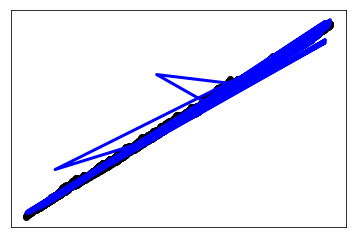

In [214]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, predictions, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [184]:
print("Index| prediction |Actual result| error")

#for prediction in predictions:
 #   print(prediction)
station = 10
count = 0
errors = []
for i in y_test.index:
    error = predictions[count][station] - y_test.loc[i][station]
    #print(i, "\t", predictions[count][station],"\t", y_test.loc[i][station], "\t", error) 
    errors.append(error)
    count += 1
ErrorArray.append(errors)

Index| prediction |Actual result| error


In [185]:
#print(ErrorArray)

In [186]:
print(len(ErrorArray))

1


In [171]:
import numpy as np
newErrorArray = np.transpose(ErrorArray)

In [172]:
df = pd.DataFrame(data=newErrorArray,columns=['Group1','Group2','Group3', 'Group4','Group5'])
df['BASELINE'] = 0

In [173]:
df.BASELINE.count()

5

<Figure size 432x288 with 0 Axes>

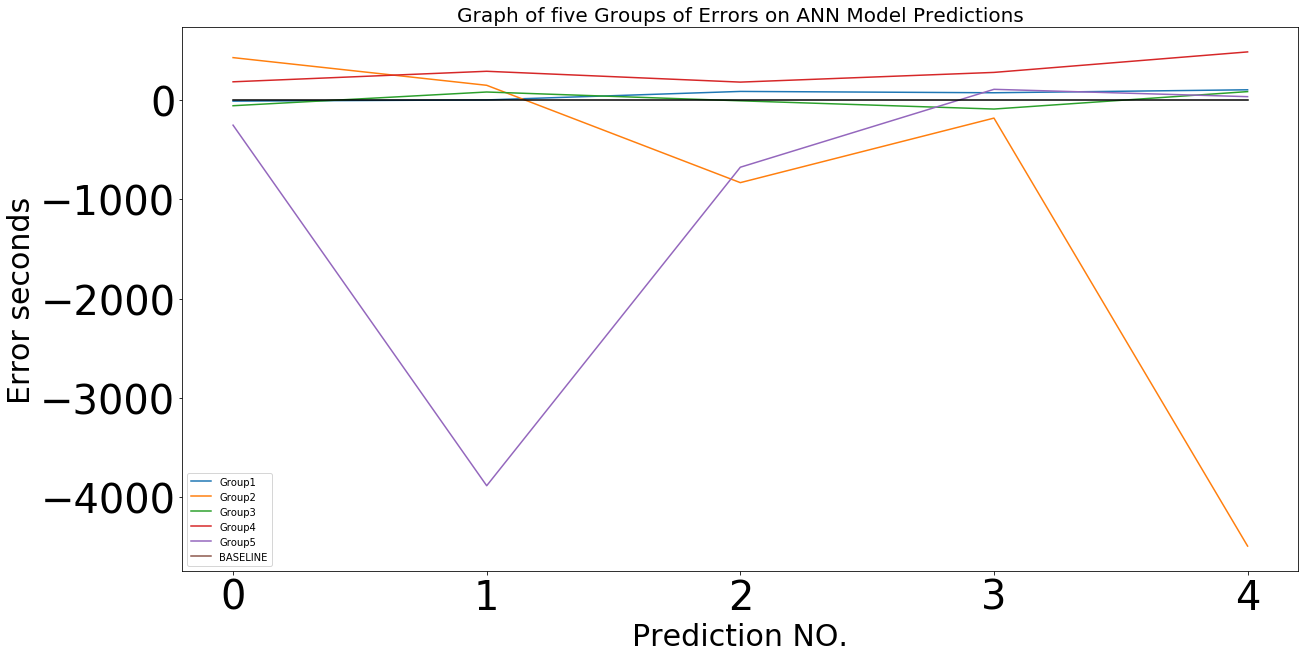

In [175]:
import matplotlib.pyplot as plt
plt.figure()
df.plot(figsize=(20, 10),fontsize=40)
plt.gca().get_lines()[5].set_color("black")
plt.title('Graph of five Groups of Errors on ANN Model Predictions', fontsize=20)
plt.xlabel('Prediction NO.',fontsize=30)
plt.ylabel('Error seconds',fontsize=30)
#fig.suptitle('test title', fontsize=20)
#axis(side=1, at=c(0:23))
#start, end = ax.get_xlim()
#ax.xaxis.set_ticks(np.arange(start, end, 1))
plt.xticks(np.arange(0, 5, 1))
plt.show()

In [58]:
print("Index| prediction |Actual result| error")

#for prediction in predictions:
 #   print(prediction)
station_1 = 10
station_2 = 25
count = 0
for i in y_test.index:
    oneRow = predictions[count]
    prediction = oneRow[station_2] - oneRow[station_1]
    actual = y_test.loc[i][station_2] - y_test.loc[i][station_1]
    print(i, "\t", prediction,"\t", actual, "\t", prediction - actual) 
    #print(predictions[count])
    #print(y_test.loc[i])
    count += 1

Index| prediction |Actual result| error
7 	 1576.7700636998925 	 1708 	 -131.2299363001075
2 	 1444.0872672276746 	 1898 	 -453.9127327723254
12 	 1461.5388939069162 	 1604 	 -142.4611060930838
6 	 1611.0082444340587 	 1885 	 -273.9917555659413
3 	 1399.624308086266 	 1312 	 87.62430808626596


In [20]:
new_y_test = y_test.reset_index(drop=True)

In [21]:
index_array = list(range(len(predictions)))
newPredictions = np.array(predictions).tolist()

In [22]:
#predictions
from pandas import Series, DataFrame
ser = Series(newPredictions, index=index_array)
#print(ser)

In [23]:
prediction_df = DataFrame(newPredictions, index=index_array, columns = ['Predicted_Arr', 'Predicted_Dep'])

In [24]:
plot_df = new_y_test.join(prediction_df)

In [25]:
plot_df.sort_values("ActualTime_Arr", inplace=True)
plot_df = plot_df.drop(['ActualTime_Dep', 'Predicted_Dep'], axis=1)

In [26]:
plot_df = plot_df.reset_index(drop=True)

In [27]:
plot_df.head()

,ActualTime_Arr,Predicted_Arr
0,19129,19316.893764
1,19159,19316.464773
2,19176,19355.840375
3,19193,19355.408980
4,19196,19316.670475


<Figure size 432x288 with 0 Axes>

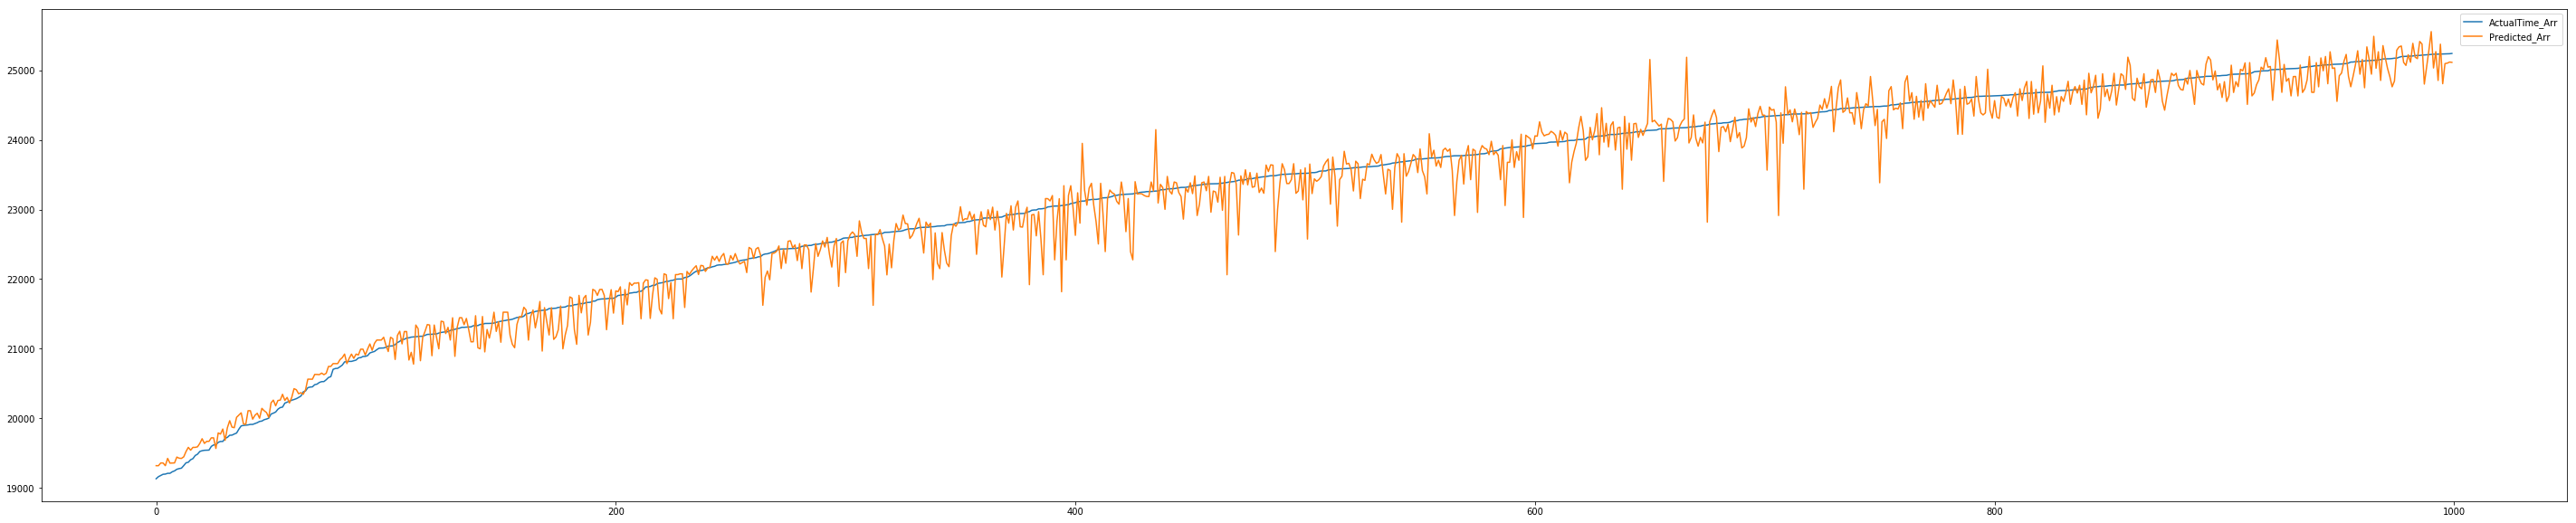

In [29]:
import matplotlib.pyplot as plt
plt.figure()
plot_df[:1000].plot(figsize=(50, 10))
plt.show()

In [71]:
# Storage Trained model in a file
'''
import pickle
file = "39A_2017_06.clf"
output = open(file, 'wb')
pickle.dump(clf, output)
output.close()
'''

In [72]:
file = "39A_2017_06.clf"
pkl_file = open(file, 'rb')
new_clf = pickle.load(pkl_file)

In [18]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
def generalCrossValidationData(n_folds=10):
    '''
        This function is to separate DataFrame into k folds groups, each group include 90% train data and 10% test data,
        which is followed k-folds Cross-validation model.
        Input Value:
                - the number of folds, default is 10 folds
        Retrun Value:
                - ({k groups of train dataset}, {k group of test dataset})
    '''
    # Reading from a csv file, into a data frame
    # Drop 'customer' column because it is not continuous feature
    # Randomly shuffle the dataset
    # here you get 70% of the rows for train
    # this code tries to find that train = 70% and test = 30%
    #df = pd.read_csv("39A_73stations_JUN.csv")
    df = pd.read_csv("FINAL_39A_73stations_JUN.csv")

    # X Descriptive features (6 continous features)
    # y Target feature (happiness_class)
    a_columns = []
    b_columns = []
    # 74 is the total number of 39A bus stations
    #columns = []
    for i in range(1,74):
        a_columns.append('a_{}'.format(i))
        b_columns.append('b_{}'.format(i))
    all_columns = a_columns + b_columns
    new_df = pd.concat([df[all_columns]], axis=1)
 
    # we use k-folds cross validation model and we separate the data into 10 groups of train & test datasets
    # we use KFold method to separate the dataset based 10-folds Cross-validation rule
    from sklearn.cross_validation import KFold
    kf = KFold(len(new_df), n_folds=n_folds)
    train_index = {}
    test_index = {}
    count = 0
    for indexA, indexB in kf:
        train_index[count] = indexA
        test_index[count] = indexB
        count += 1

    trains = {}
    tests = {}
    for i in range(10):
        trains[i] = new_df.loc[train_index[i]]
        tests[i] = new_df.loc[test_index[i]]
    return (trains, tests)

In [19]:
trains, tests = generalCrossValidationData(10)

In [20]:
trains[0].head()

,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,...,b_64,b_65,b_66,b_67,b_68,b_69,b_70,b_71,b_72,b_73
65,43200,43330,43353,43397,43415,43452,43494,43543,43609,43670,...,49182,49273,49308,49353,49429,49497,49524,49577,49631,49703
66,43200,43330,43353,43397,43415,43452,43494,43543,43609,43670,...,48270,48351,48368,48410,48494,48581,48609,48670,48704,48727
67,55200,55366,55396,55459,55485,55538,55569,55606,55656,55717,...,60898,60957,60999,61039,61122,61209,61242,61310,61343,61369
68,55200,55366,55396,55459,55485,55538,55569,55606,55656,55717,...,60674,60765,60783,60820,60894,60969,61002,61062,61091,61110
69,68400,68520,68580,68634,68656,68700,68748,68804,68880,68940,...,72640,72728,72768,72830,72894,72977,72991,73065,73075,73075


In [21]:
# 10-fold crossing validation testing
scores = 0
vscores = 0
MSES = 0
a_columns = []
b_columns = []
for i in range(1,74):
        a_columns.append('a_{}'.format(i))
        b_columns.append('b_{}'.format(i))
#all_columns = a_columns + b_columns
# BP neural networking training
import numpy as np
#from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
# X Descriptive features (4 features)
# y Target feature (TripDuration)
scores = 0
for i in range(10):
    train = trains[i]
    test = tests[i]
    
    train_X = pd.concat([train[a_columns]], axis=1)
    train_y = train[b_columns]
    train_X = train_X.fillna(train_X.mean())
    train_y = train_y.fillna(train_y.mean())
    
    test_X = pd.concat([test[a_columns]])
    test_y = test[b_columns]
    test_X = test_X.fillna(test_X.mean())
    test_y = test_y.fillna(test_y.mean())
    
    # Instantiate model
    # 99% score
    clf = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(10, 10, 10), random_state=1)
    clf.fit(train_X,train_y)

    # Fit Model
    clf.fit(train_X, train_y)
    score = clf.score(test_X, test_y)
    scores += score
    print("test {} Score: {}".format(i+1,score))
    
    # Make predictions using the testing set
    diabetes_y_pred = clf.predict(test_X)
     # The mean squared error
    MSE = mean_squared_error(test_y, diabetes_y_pred)
    MSES += MSE
    print("\tMean squared error: %.2f"
      % MSE)
    
    # Explained variance score: 1 is perfect prediction
    vscore = r2_score(test_y, diabetes_y_pred)
    vscores += vscore
    print('\tVariance score: %.2f' % vscore)
print("Average of Score is: ", scores/10)
print("Average of MSES is: ", MSES/10)
print("Average of vscore is: ", vscores/10)

test 1 Score: 0.9980612472240128
	Mean squared error: 474681.92
	Variance score: 1.00
test 2 Score: 0.9980666412024269
	Mean squared error: 502927.68
	Variance score: 1.00
test 3 Score: 0.9982916832005889
	Mean squared error: 433004.50
	Variance score: 1.00
test 4 Score: 0.9980953007114689
	Mean squared error: 462570.32
	Variance score: 1.00
test 5 Score: 0.9980845955522075
	Mean squared error: 389437.20
	Variance score: 1.00
test 6 Score: 0.9978399610579108
	Mean squared error: 445156.90
	Variance score: 1.00
test 7 Score: 0.989804892130481
	Mean squared error: 2839475.94
	Variance score: 0.99
test 8 Score: 0.9981414108179145
	Mean squared error: 381302.15
	Variance score: 1.00
test 9 Score: 0.9982026147195748
	Mean squared error: 369252.06
	Variance score: 1.00
test 10 Score: 0.9981324182424731
	Mean squared error: 444956.10
	Variance score: 1.00
Average of Score is:  0.9972720764859059
Average of MSES is:  674276.4765849254
Average of vscore is:  0.9972739506403508
